In [20]:
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.sparse import csr_matrix
os.chdir(os.path.expanduser('~/vEcoli'))

In [21]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

# data from Cyrus:
Cmatrix = read_matrix("notebooks/mia_notebooks/protein_count_comparison_files/C_matrix.csv", sparse=True)
complex_ids = list(read_names("notebooks/mia_notebooks/protein_count_comparison_files/complex_ids.txt"))
monomer_ids = list(read_names("notebooks/mia_notebooks/protein_count_comparison_files/monomer_ids.txt"))

# Ecocyc data (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
ecocyc_data = pd.read_excel("notebooks/mia_notebooks/protein_count_comparison_files/All_polypeptides_from_ecocyc_data.xlsx")

# validation data (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_data = pd.read_excel("notebooks/mia_notebooks/protein_count_comparison_files/data_from_li_et_al_2014.xlsx")

## Minimal Media Conditions Comparison: Simulation data VS "MOPS minimal" data from Li et al., 2014 

In [22]:
#todo figure out why this no longer works!! for some reason it appears the bulk data is missing things?
# time = '1300'
# date = '2024-04-29'
# experiment = 'validation_experiment'
# entry = f'{experiment}_{time}_{date}'
# folder = f'out/cofactors/{entry}/'

In [23]:
# new data from simulation on 2024-07-16
time = '1300'
date = '2024-07-16'
experiment = 'metabolism-redux-classic'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [24]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [25]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
# TODO ask cyrus about this 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

bulk.columns = bulk_ids

In [26]:
#bulk_ids

In [27]:
np.shape(bulk.columns) # 16097

(16255,)

In [28]:
# Combine monomers in different compartments into one monomer id: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)
	
all_names = [] # ends with 12726 total (down from 16097)
name_groups = []
idx_groups = []

for p in bulk_ids:
	prot = p[0:-3]
	if prot not in all_names:
		indexes = [index for index, item in enumerate(ecocyc_ids) if item == prot]
		for idx in indexes:
			if ecocyc_ids[idx] == prot:
				# confirm the index is correct
				pass
			else:
				# delete the index in case a mistake was made
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(prot)
		name_groups.append(name_group)
		idx_groups.append(indexes)
		
len(all_names)
len(name_groups)

12788

In [29]:
# figure out which proteins from the C matrix match those in the bulk data: 
protein_ids = complex_ids + monomer_ids
protein_counts = np.zeros([bulk.shape[0], len(protein_ids)])
pid_idx_dict = {id: i for i, id in enumerate(protein_ids)}
idx_pid_dict = {idx: i for i, idx in pid_idx_dict.items()}

for p in protein_ids:
	idx = [index for index, item in enumerate(all_names) if item == p]
	if len(idx) == 0:
		protein_counts[:, pid_idx_dict[p]] = 0
	elif len(idx) == 1:
		name = all_names[idx[0]]
		idx_group = idx_groups[idx[0]]
		temp_counts = np.zeros([bulk.shape[0], len(idx_group)])
		for i in range(len(idx_group)):
			selected_data = bulk.select(bulk_ids[idx_group[i]]) 
			temp_counts[:, i] = selected_data.to_numpy().flatten()
		protein_counts[:, pid_idx_dict[p]] = np.sum(temp_counts, axis=1)
	else:
		# make sure there are no bugs in the code
		print(p)
		print("too many")
	

In [30]:
np.shape(protein_counts)

(1301, 5527)

In [31]:
mm_sim_protein_counts = protein_counts @ Cmatrix
# simplify the results accordingly with the time steps: 
mm_avg_sim_data = mm_sim_protein_counts.mean(axis=0)
# TODO: edit this to account for cell age
# create dataframes for the simulation data:
mm_avg_sim_df = pl.DataFrame((monomer_ids, mm_avg_sim_data), schema=["Monomer ID","Sim Protein Counts"])

In [32]:
mm_avg_sim_df

Monomer ID,Sim Protein Counts
str,f64
"""1-ACYLGLYCEROL-3-P-ACYLTRANSFE…",176.874712
"""1-PFK-MONOMER""",57.001537
"""2-DEHYDROPANTOATE-REDUCT-MONOM…",217.187548
"""2-ISOPROPYLMALATESYN-MONOMER""",1630.80784
"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…",322.077633
…,…
"""YTFR-MONOMER""",25.0
"""YTFT-MONOMER""",21.0
"""ZNUA-MONOMER""",570.823213


In [33]:
new_df = pl.DataFrame(ecocyc_data).join(mm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
# TODO: so the length of the original ecocyc data frame is 4481, so I think that it is filtering correctly! 
new_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts
str,str,str,str,f64
"""EG11817-MONOMER""","""EG11817""","""b2744""","""umpG""",88.013067
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",262.318217
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",22.0
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",195.0
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",171.176018
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",73.601845
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",296.885473
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",19.0


In [34]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(str)
validation_data = validation_data[~validation_data['MOPS minimal'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS minimal'].str.isdigit()]
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(int)
v_mm_data = validation_data[['Gene', 'MOPS minimal']]
v_mm_data = pl.DataFrame(v_mm_data)
v_mm_data

Gene,MOPS minimal
str,i64
"""aaeA""",5
"""aaeR""",79
"""aas""",80
"""aat""",111
"""abgA""",12
…,…
"""zraR""",30
"""zraS""",4
"""zupT""",217


In [35]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_mm_df = pl.DataFrame(new_df).join(v_mm_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_mm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts,MOPS minimal
str,str,str,str,f64,i64
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",262.318217,572
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",22.0,16
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",171.176018,265
"""EG10875-MONOMER""","""EG10875""","""b3310""","""rplN""",11426.142967,18836
"""G6605-MONOMER""","""G6605""","""b1165""","""ymgA""",27.679477,43
…,…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",73.601845,19
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",296.885473,2360
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",19.0,37


In [36]:
# make a new data frame that holds just the protein names and the Sim Protein Counts and MOPS minimal data and then filter out counts that are less than 10: 
comparison_data = ["Proteins", "Sim Protein Counts", "MOPS minimal"]
comparison_df = vs_match_mm_df.select(comparison_data)
comparison_df = comparison_df.filter((pl.col("Sim Protein Counts") > 10) & (pl.col("MOPS minimal") > 10))
comparison_df

Proteins,Sim Protein Counts,MOPS minimal
str,f64,i64
"""MONOMER0-4534""",262.318217,572
"""FDOI-MONOMER""",22.0,16
"""ADENODEAMIN-MONOMER""",171.176018,265
"""EG10875-MONOMER""",11426.142967,18836
"""G6605-MONOMER""",27.679477,43
…,…,…
"""G7835-MONOMER""",73.601845,19
"""GALACTITOLPDEHYD-MONOMER""",296.885473,2360
"""EG10736-MONOMER""",19.0,37


In [37]:
np.shape(comparison_df)

(2656, 3)

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data')

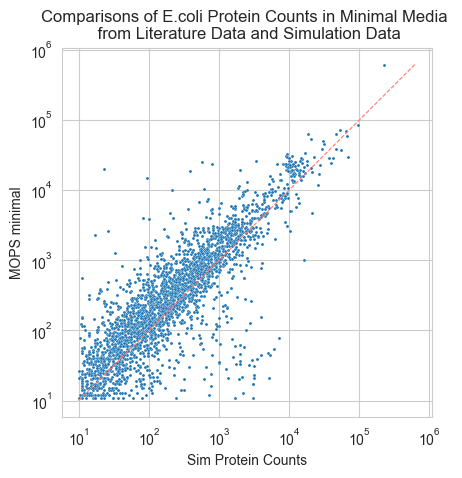

In [39]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS minimal", data=comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(comparison_df["Sim Protein Counts"]), max(comparison_df["MOPS minimal"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data")

In [41]:
# plot the comparison graph with plotly:
df = comparison_df.to_pandas()
fig = px.scatter(df, x=df["Sim Protein Counts"],y=df["MOPS minimal"], hover_data=["Proteins"], trendline="ols" )
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode="lines",
        line=go.scatter.Line(color="red", dash="dash"),
        showlegend=False));

fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_layout(title="Comparisons of E.coli Protein Counts in Minimal Media \nfrom Literature Data (Li, et. al., 2014) and Simulation Data")
# make the figure square and have equal axis numbers
fig.update_layout(width=800, height=800)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show()

## Rich Media Conditions Comparison: Simulation data VS "MOPS complete" data from Li et al., 2014 


In [ ]:
# simulation from 2024-06-13 (created with the vivarium-ecoli model, and it does produce an output on the new vEcoli model)
# time = '1300'
# date = '2024-06-13'
# experiment = 'metabolism-redux-classic-rich'
# entry = f'{experiment}_{time}_{date}'
# folder = f'out/cofactors/{entry}/'

In [42]:
time = '1300'
date = '2024-07-16'
experiment = 'metabolism-redux-classic-rich'
#experiment = 'validation_experiment'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [43]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
rm_bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [44]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

rm_bulk.columns = bulk_ids
# TODO: I need ot re run the sims with the new viv update 

In [45]:
# TODO: do I need this next section in here twice? will it be the same every time? ask cyrus if the same proteins will likely show up out of both sim types, even if they are different conditions


In [46]:
# Combine monomers in different compartments into one monomer id: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)
	
all_names = [] # ends with 12726 total (down from 16097)
name_groups = []
idx_groups = []

for p in bulk_ids:
	prot = p[0:-3]
	if prot not in all_names:
		indexes = [index for index, item in enumerate(ecocyc_ids) if item == prot]
		for idx in indexes:
			if ecocyc_ids[idx] == prot:
				# confirm the index is correct
				pass
			else:
				# delete the index in case a mistake was made
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(prot)
		name_groups.append(name_group)
		idx_groups.append(indexes)
		
len(all_names)
len(name_groups)

12788

In [47]:
# figure out which proteins from the C matrix match those in the bulk data: 
protein_ids = complex_ids + monomer_ids
protein_counts = np.zeros([rm_bulk.shape[0], len(protein_ids)])
pid_idx_dict = {id: i for i, id in enumerate(protein_ids)}
idx_pid_dict = {idx: i for i, idx in pid_idx_dict.items()}

for p in protein_ids:
	idx = [index for index, item in enumerate(all_names) if item == p]
	if len(idx) == 0:
		protein_counts[:, pid_idx_dict[p]] = 0
	elif len(idx) == 1:
		name = all_names[idx[0]]
		idx_group = idx_groups[idx[0]]
		temp_counts = np.zeros([rm_bulk.shape[0], len(idx_group)])
		for i in range(len(idx_group)):
			selected_data = rm_bulk.select(bulk_ids[idx_group[i]]) 
			temp_counts[:, i] = selected_data.to_numpy().flatten()
		protein_counts[:, pid_idx_dict[p]] = np.sum(temp_counts, axis=1)
	else:
		# make sure there are no bugs in the code
		print(p)
		print("too many")
	

In [48]:
np.shape(protein_counts)


(1301, 5527)

In [49]:
rm_sim_protein_counts = protein_counts @ Cmatrix
# simplify the results accordingly with the time steps: 
rm_avg_sim_data = rm_sim_protein_counts.mean(axis=0)
# TODO: edit this to account for cell age
# create dataframes for the simulation data:
rm_avg_sim_df = pl.DataFrame((monomer_ids, rm_avg_sim_data), schema=["Monomer ID","Sim Protein Counts"])

In [50]:
rm_df = pl.DataFrame(ecocyc_data).join(rm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
rm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts
str,str,str,str,f64
"""EG11817-MONOMER""","""EG11817""","""b2744""","""umpG""",186.411222
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",937.099923
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",72.946964
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",547.750961
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",364.110684
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",195.53651
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",846.579554
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",40.270561


In [51]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS complete'] = validation_data['MOPS complete'].astype(str)
validation_data = validation_data[~validation_data['MOPS complete'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS complete'].str.isdigit()]
validation_data['MOPS complete'] = validation_data['MOPS complete'].astype(int)
v_rm_data = validation_data[['Gene', 'MOPS complete']]
v_rm_data = pl.DataFrame(v_rm_data)
v_rm_data

Gene,MOPS complete
str,i64
"""aaeA""",62
"""aaeR""",203
"""aas""",188
"""aat""",151
"""abgA""",9
…,…
"""zraR""",98
"""zraS""",8
"""zupT""",407


In [52]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_rm_df = pl.DataFrame(rm_df).join(v_rm_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_rm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts,MOPS complete
str,str,str,str,f64,i64
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",937.099923,827
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",72.946964,221
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",364.110684,724
"""EG10875-MONOMER""","""EG10875""","""b3310""","""rplN""",23871.555726,118153
"""G6605-MONOMER""","""G6605""","""b1165""","""ymgA""",157.213682,48
…,…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",195.53651,45
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",846.579554,643
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",40.270561,21


In [53]:
# make a new data frame that holds just the protein names and the Sim Protein Counts and MOPS minimal data and then filter out counts that are less than 10: 
rm_comparison_data = ["Proteins", "Sim Protein Counts", "MOPS complete"]
rm_comparison_df = vs_match_rm_df.select(rm_comparison_data)
rm_comparison_df = rm_comparison_df.filter((pl.col("Sim Protein Counts") > 10) & (pl.col("MOPS complete") > 10))
rm_comparison_df

Proteins,Sim Protein Counts,MOPS complete
str,f64,i64
"""MONOMER0-4534""",937.099923,827
"""FDOI-MONOMER""",72.946964,221
"""ADENODEAMIN-MONOMER""",364.110684,724
"""EG10875-MONOMER""",23871.555726,118153
"""G6605-MONOMER""",157.213682,48
…,…,…
"""G7835-MONOMER""",195.53651,45
"""GALACTITOLPDEHYD-MONOMER""",846.579554,643
"""EG10736-MONOMER""",40.270561,21


In [54]:
np.shape(rm_comparison_df)

(2624, 3)

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data')

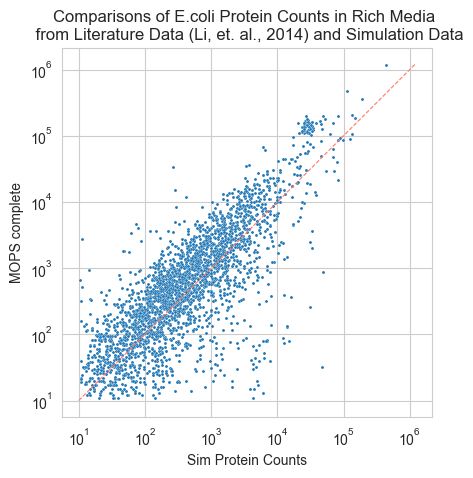

In [55]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete", data=rm_comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(rm_comparison_df["Sim Protein Counts"]), max(rm_comparison_df["MOPS complete"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Rich Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")

In [56]:
# plot the comparison graph with plotly:
df = rm_comparison_df.to_pandas()
fig = px.scatter(df, x=df["Sim Protein Counts"],y=df["MOPS complete"], hover_data=["Proteins"], trendline="ols" )
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode="lines",
        line=go.scatter.Line(color="red", dash="dash"),
        showlegend=False));

fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_layout(title="Comparisons of E.coli Protein Counts in Rich Media\nfrom Literature Data (Li, et. al., 2014) and Simulation Data")
# make the figure square and have equal axis numbers
fig.update_layout(width=800, height=800)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show()

# Rich Media (without methionine) Conditions Comparison: Simulation data VS "MOPS complete without methionine" data from Li et al., 2014) 

In [ ]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS complete without methionine'] = validation_data['MOPS complete without methionine'].astype(str)
validation_data = validation_data[~validation_data['MOPS complete without methionine'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS complete without methionine'].str.isdigit()]
validation_data['MOPS complete without methionine'] = validation_data['MOPS complete without methionine'].astype(int)
v_rmwom_data = validation_data[['Gene', 'MOPS complete without methionine']]
v_rmwom_data = pl.DataFrame(v_rmwom_data)
v_rmwom_data

In [ ]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_rmwom_df = pl.DataFrame(rm_df).join(v_rmwom_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_rmwom_df

In [ ]:
# make a new data frame that holds just the protein names and the Sim Protein Counts and MOPS minimal data and then filter out counts that are less than 10: 
rmwom_comparison_data = ["Proteins", "Sim Protein Counts", "MOPS complete without methionine"]
rmwom_comparison_df = vs_match_rmwom_df.select(rmwom_comparison_data)
rmwom_comparison_df = rmwom_comparison_df.filter((pl.col("Sim Protein Counts") > 10) & (pl.col("MOPS complete without methionine") > 10))
rmwom_comparison_df

In [ ]:
np.shape(rmwom_comparison_df)

In [ ]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS complete without methionine", data=rmwom_comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(rmwom_comparison_df["Sim Protein Counts"]), max(rmwom_comparison_df["MOPS complete without methionine"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Rich Media (without Methionine) \n from Literature Data (Li, et. al., 2014) and Simulation Data")

In [ ]:
# plot the comparison graph with plotly:
df = rmwom_comparison_df.to_pandas()
fig = px.scatter(df, x=df["Sim Protein Counts"],y=df["MOPS complete without methionine"], hover_data=["Proteins"], trendline="ols" )
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode="lines",
        line=go.scatter.Line(color="red", dash="dash"),
        showlegend=False));

fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_layout(title="Comparisons of E.coli Protein Counts in Rich Media (w/o methionine) \nfrom Literature Data (Li, et. al., 2014) and Simulation Data")
# make the figure square and have equal axis numbers
fig.update_layout(width=800, height=800)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show()